# Dam Growth Analysis in Arid Sub-Saharan Africa (SSA)
This notebook analyzes the growth and distribution of dams in arid regions of Sub-Saharan Africa for the years 2000 and 2021. It uses utility functions for configuration and spatial operations to ensure code clarity and reusability.

In [1]:
# --- Import Required Libraries and Utilities ---
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize, TwoSlopeNorm
import numpy as np
import os
import sys

# Add the project root to sys.path so we can import from Code.utils everywhere
project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from Code.utils.utility import load_config, resolve_path

# Load configuration
config = load_config()

## Data Loading and Preprocessing
Load arid SSA shapefile, Africa boundaries, and dam locations. Simplify geometries for faster plotting. Use utility functions for path resolution.

In [2]:
# --- Load and Prepare Spatial Data ---
# Load arid SSA regions and Africa boundaries
arid_ssa_shapefile = gpd.read_file(resolve_path(config['SSA_Arid_by_Country_shp_path']))
arid_ssa_shapefile['geometry'] = arid_ssa_shapefile['geometry'].simplify(0.01)
af_bnds = gpd.read_file(resolve_path(config['Africa_boundaries_shp_path']))
af_bnds['geometry'] = af_bnds['geometry'].simplify(0.01)

# Load and process dams data
# Replace -99 with NaN for year columns
# Filter for dams present in 2000 and 2021
# Only keep dams within arid SSA regions

dams = gpd.read_file(resolve_path(config['GDW_barrier_shp_path']))
dams = dams.to_crs("EPSG:4326")
dams['PRE_YEAR'] = dams['PRE_YEAR'].replace(-99, np.nan)
dams['REM_YEAR'] = dams['REM_YEAR'].replace(-99, np.nan)

def filter_dams_by_year(dams, year):
    return dams[
        ((dams['YEAR_DAM'] <= year) | (dams['PRE_YEAR'] <= year)) &
        ((dams['REM_YEAR'].isnull()) | (dams['REM_YEAR'] > year))
    ]

dams_2000 = filter_dams_by_year(dams, 2000)
dams_2021 = filter_dams_by_year(dams, 2021)

def dams_in_arid_ssa(dams_df, arid_shp):
    return gpd.sjoin(dams_df, arid_shp, how='inner', predicate='within')

dams_2000_in_arid_ssa = dams_in_arid_ssa(dams_2000, arid_ssa_shapefile)
dams_2021_in_arid_ssa = dams_in_arid_ssa(dams_2021, arid_ssa_shapefile)

print(f"Dams in Arid SSA (2000): {len(dams_2000_in_arid_ssa)}")
print(f"Dams in Arid SSA (2021): {len(dams_2021_in_arid_ssa)}")

/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/shapely/constructive.py:862: RuntimeWarning: overflow encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)
/home/ermiller/miniconda3/envs/irrigation/lib/python3.12/site-packages/shapely/constructive.py:862: RuntimeWarning: invalid value encountered in simplify_preserve_topology
  return lib.simplify_preserve_topology(geometry, tolerance, **kwargs)


Dams in Arid SSA (2000): 2674
Dams in Arid SSA (2021): 2763


## Visualize Dam Locations in 2000 and 2021
Plot the locations of dams in arid SSA for both years, highlighting the change over time. Non-arid regions are hatched for context.

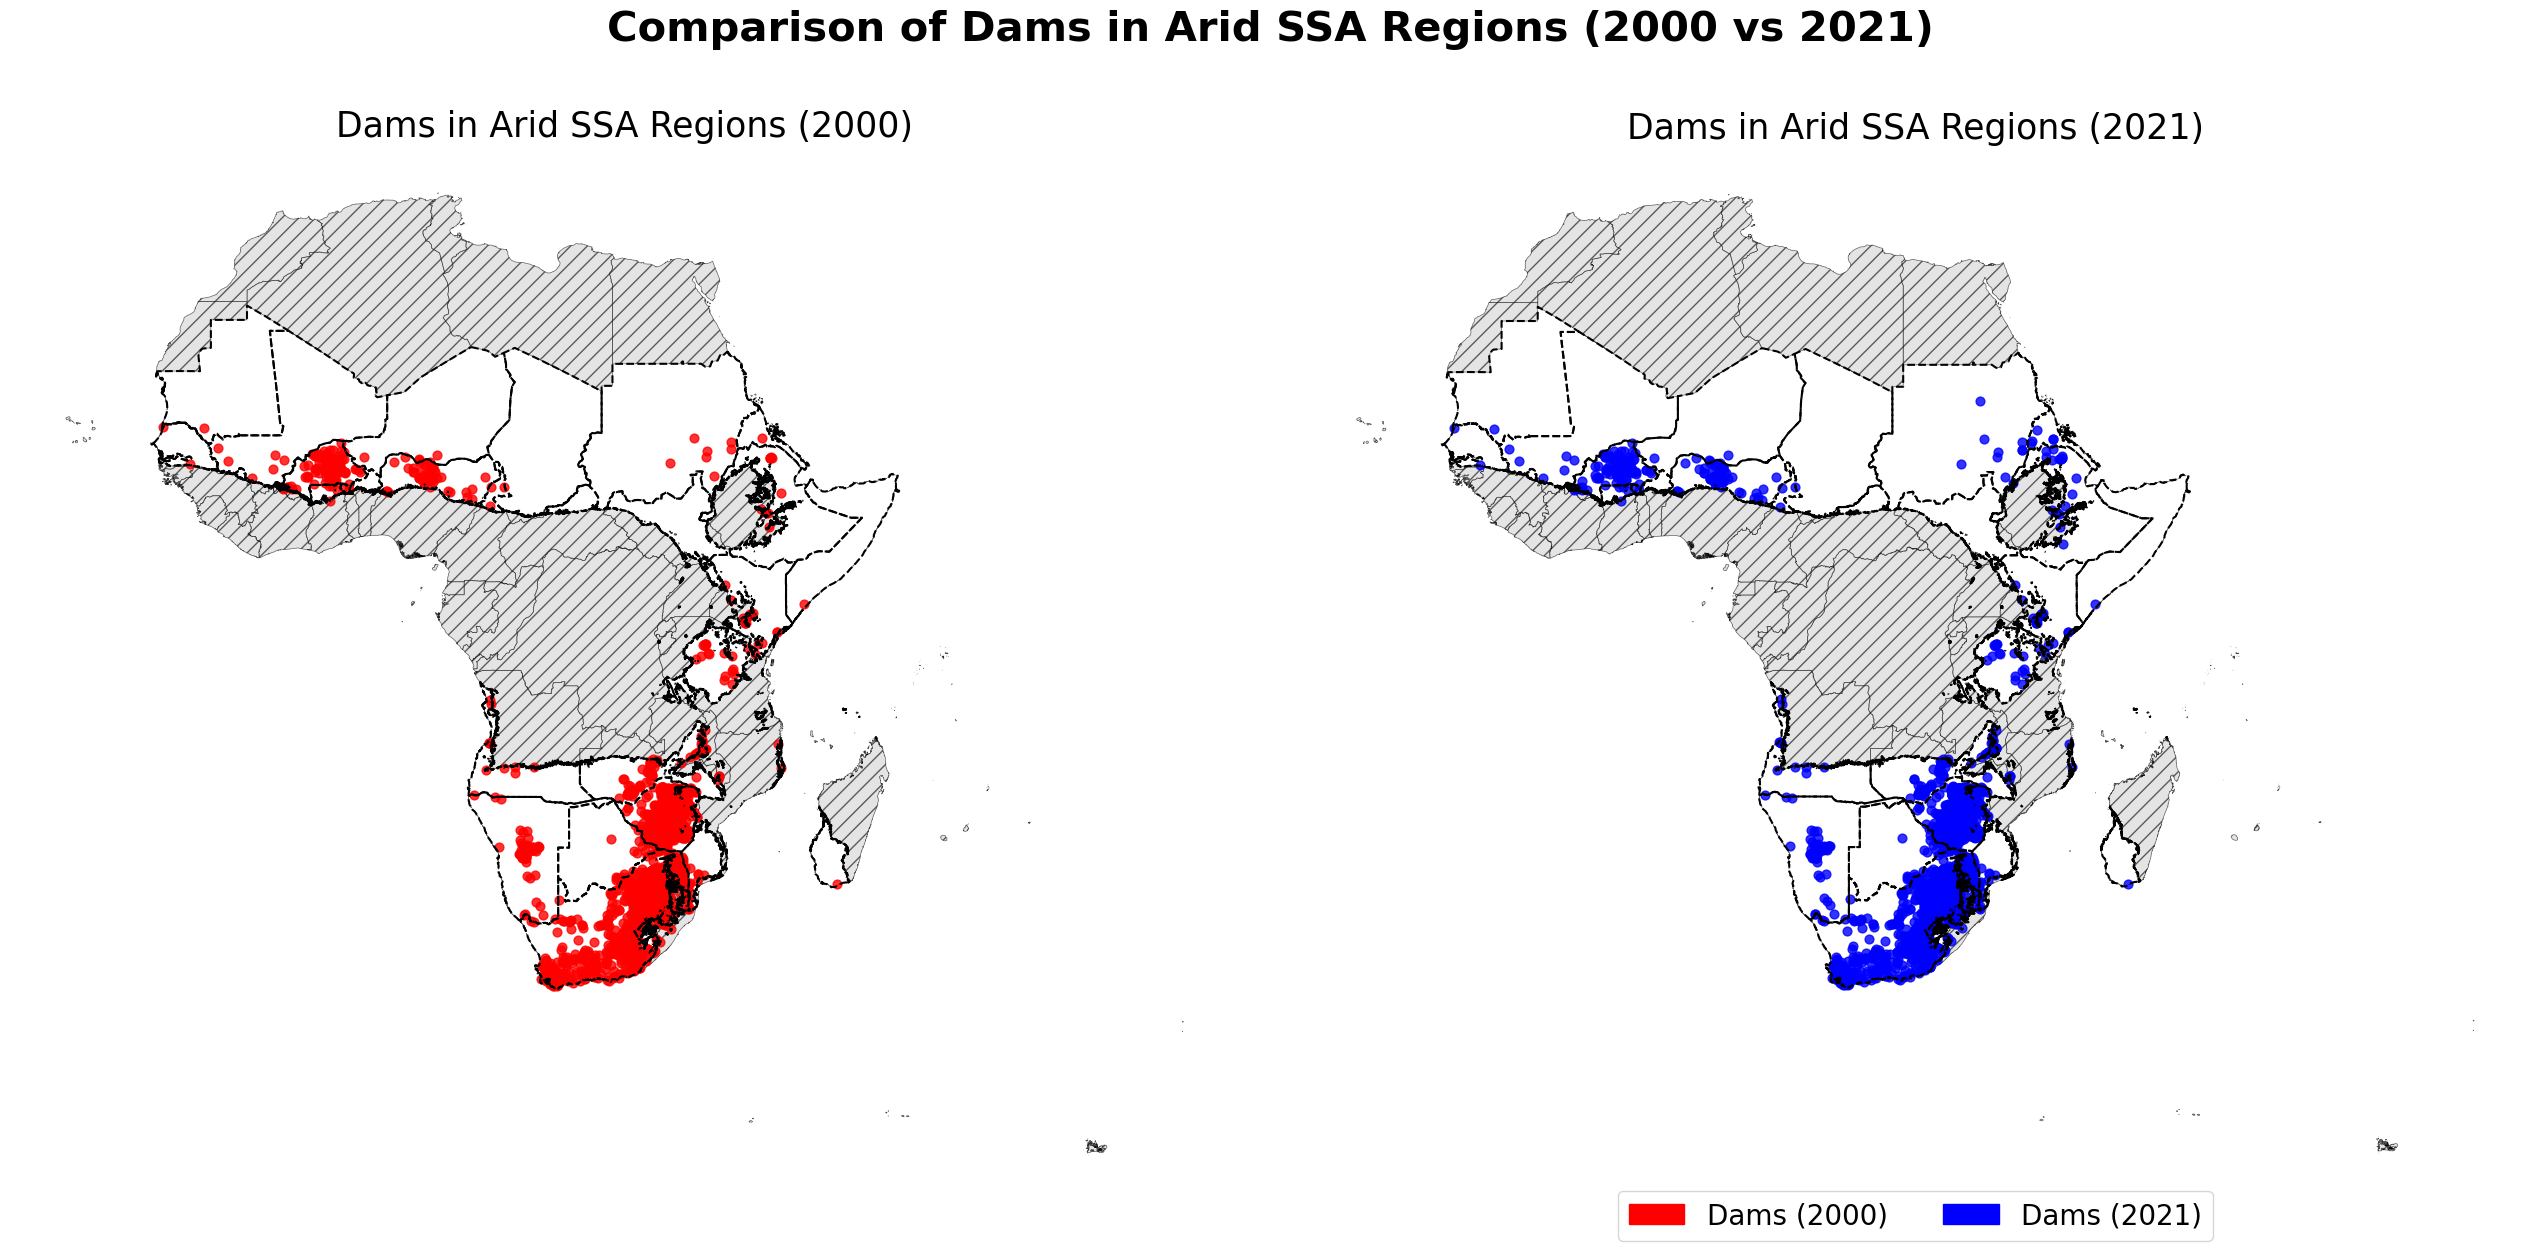

In [3]:
# --- Plot Dams in Arid SSA for 2000 and 2021 ---
fig, ax = plt.subplots(1, 2, figsize=(28, 14), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.05, hspace=0.1, left=0.05, right=0.95, top=0.9, bottom=0.05)

# Identify non-arid SSA regions for hatching
non_arid_ssa = af_bnds.overlay(arid_ssa_shapefile, how='difference', keep_geom_type=False)

# Plot for 2000
non_arid_ssa.plot(ax=ax[0], color='lightgray', edgecolor='black', hatch='//', linewidth=0.5, alpha=0.6)
arid_ssa_shapefile.boundary.plot(ax=ax[0], edgecolor='black', linewidth=1.5, linestyle='--')
dams_2000_in_arid_ssa.plot(ax=ax[0], color='red', markersize=40, label='Dams (2000)', alpha=0.8)
ax[0].set_title("Dams in Arid SSA Regions (2000)", fontsize=25)
ax[0].set_axis_off()

# Plot for 2021
non_arid_ssa.plot(ax=ax[1], color='lightgray', edgecolor='black', hatch='//', linewidth=0.5, alpha=0.6)
arid_ssa_shapefile.boundary.plot(ax=ax[1], edgecolor='black', linewidth=1.5, linestyle='--')
dams_2021_in_arid_ssa.plot(ax=ax[1], color='blue', markersize=40, label='Dams (2021)', alpha=0.8)
ax[1].set_title("Dams in Arid SSA Regions (2021)", fontsize=25)
ax[1].set_axis_off()

fig.suptitle("Comparison of Dams in Arid SSA Regions (2000 vs 2021)", fontsize=30, fontweight='bold', y=0.95)

# Combined legend
import matplotlib.patches as mpatches
red_patch = mpatches.Patch(color='red', label='Dams (2000)')
blue_patch = mpatches.Patch(color='blue', label='Dams (2021)')
plt.legend(handles=[red_patch, blue_patch], loc='lower center', fontsize=20, bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.show()

## Dam Count by Country and Change Over Time
Summarize dam counts by country for 2000 and 2021, and visualize the change in dam count per country in arid SSA.

All differences are positive. Using standard normalization.


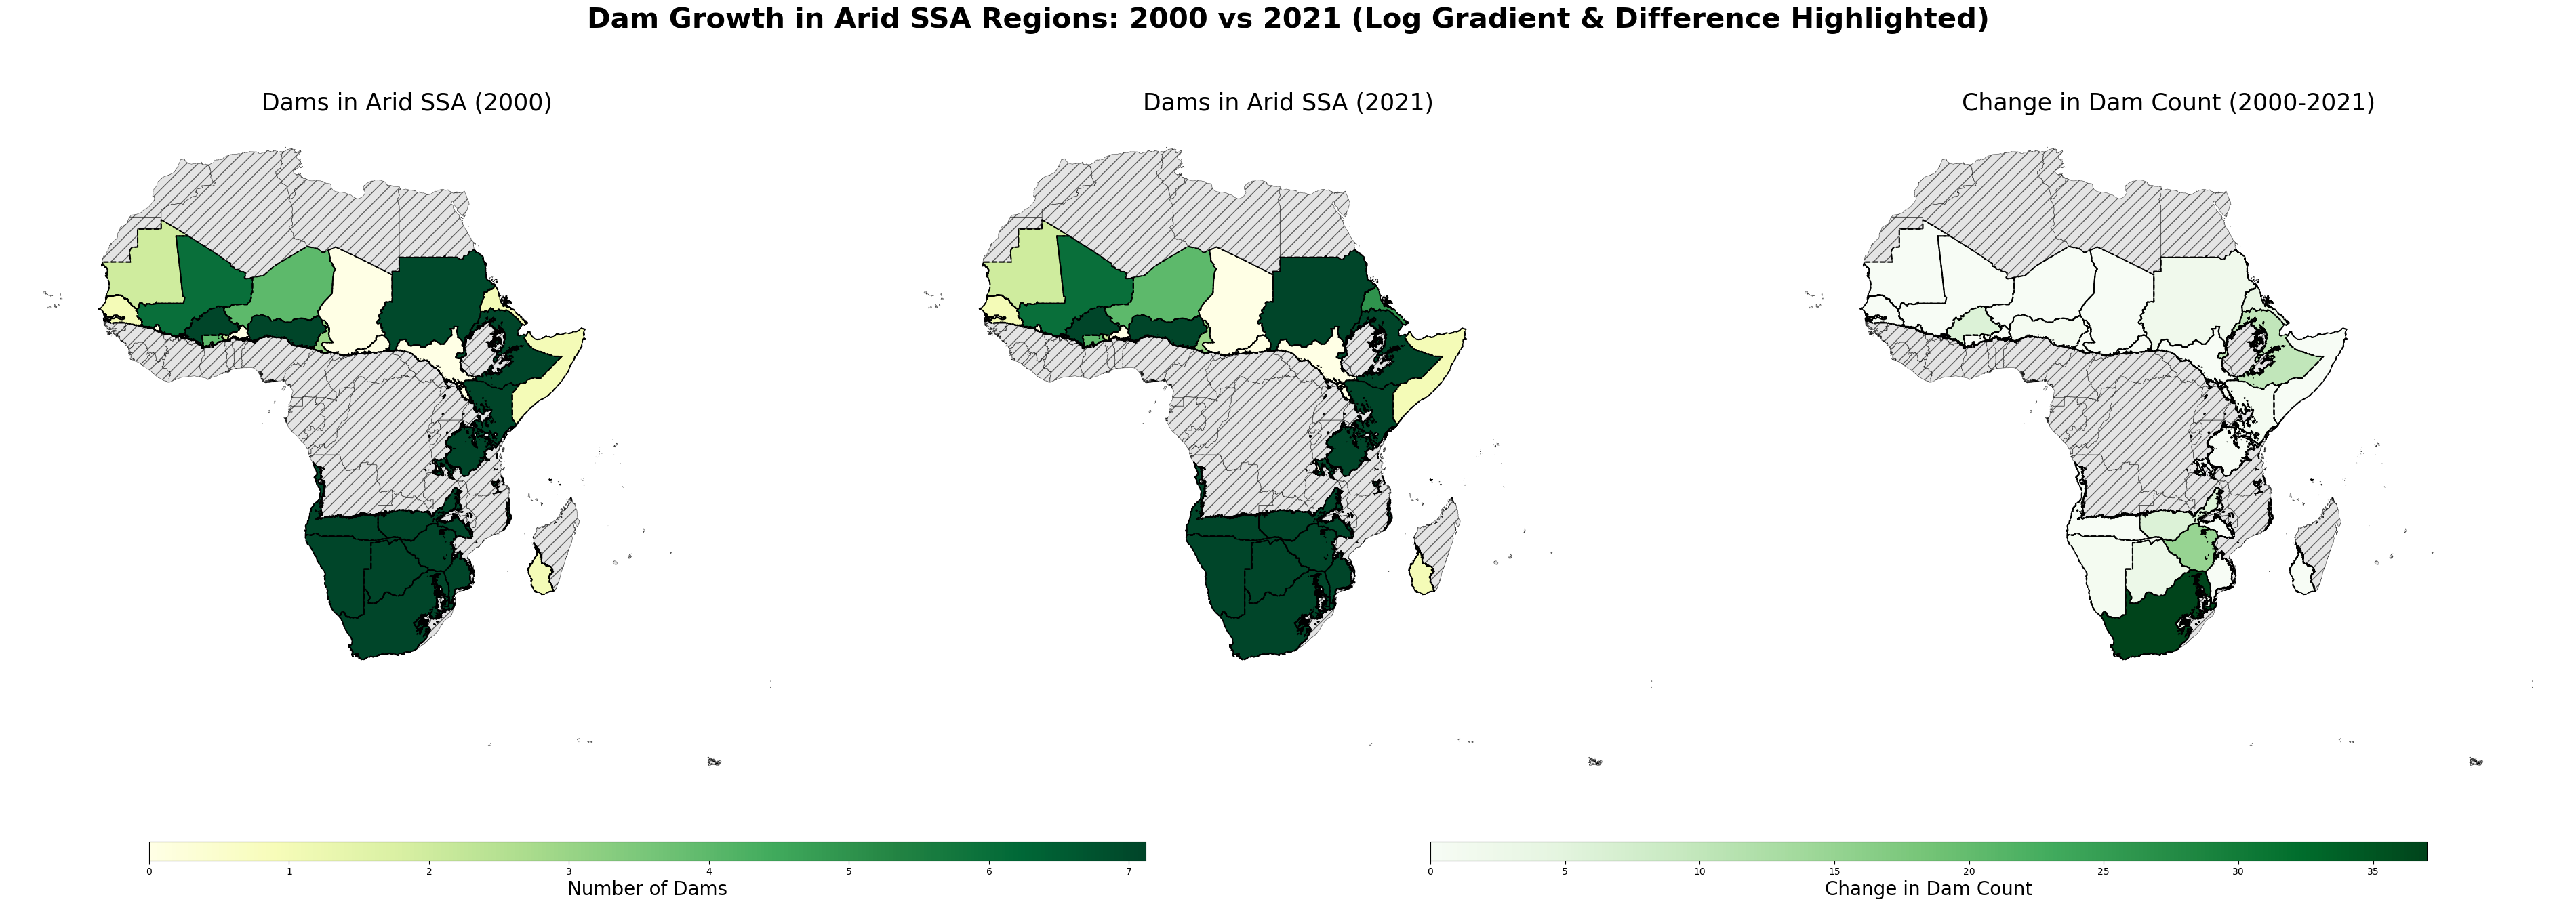

In [ ]:
# --- Calculate and Plot Dam Count Change by Country ---
# Count dams per country for each year
count_2000 = dams_2000_in_arid_ssa.groupby('ISO').size().reset_index(name='dam_count_2000')
count_2021 = dams_2021_in_arid_ssa.groupby('ISO').size().reset_index(name='dam_count_2021')

# Merge counts with arid SSA shapefile
arid_ssa_shapefile = arid_ssa_shapefile.merge(count_2000, on='ISO', how='left').fillna(0)
arid_ssa_shapefile = arid_ssa_shapefile.merge(count_2021, on='ISO', how='left').fillna(0)

# Calculate difference in dam counts
arid_ssa_shapefile['dam_diff'] = arid_ssa_shapefile['dam_count_2021'] - arid_ssa_shapefile['dam_count_2000']

# Normalization for color gradients
vmax = max(arid_ssa_shapefile[['dam_count_2000', 'dam_count_2021']].max())
norm = Normalize(vmin=0, vmax=np.log1p(vmax))

diff_min = arid_ssa_shapefile['dam_diff'].min()
diff_max = arid_ssa_shapefile['dam_diff'].max()

if diff_min >= 0:
    diff_norm = Normalize(vmin=0, vmax=diff_max)
elif diff_max <= 0:
    diff_norm = Normalize(vmin=diff_min, vmax=0)
else:
    diff_norm = TwoSlopeNorm(vmin=diff_min, vcenter=0, vmax=diff_max)

# Plot dam counts and change
fig, ax = plt.subplots(1, 3, figsize=(42, 14), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.1, hspace=0.1, left=0.05, right=0.95, top=0.9, bottom=0.05)

non_arid_ssa = af_bnds.overlay(arid_ssa_shapefile, how='difference', keep_geom_type=False)

# 2000
non_arid_ssa.plot(ax=ax[0], color='lightgray', edgecolor='black', hatch='//', linewidth=0.5, alpha=0.6)
arid_ssa_shapefile.plot(column='dam_count_2000', cmap='YlGn', linewidth=0.8, edgecolor='black', legend=False, ax=ax[0], norm=norm)
arid_ssa_shapefile.boundary.plot(ax=ax[0], edgecolor='black', linewidth=1.5, linestyle='--')
ax[0].set_title("Dams in Arid SSA (2000)", fontsize=25)
ax[0].set_axis_off()

# 2021
non_arid_ssa.plot(ax=ax[1], color='lightgray', edgecolor='black', hatch='//', linewidth=0.5, alpha=0.6)
arid_ssa_shapefile.plot(column='dam_count_2021', cmap='YlGn', linewidth=0.8, edgecolor='black', legend=False, ax=ax[1], norm=norm)
arid_ssa_shapefile.boundary.plot(ax=ax[1], edgecolor='black', linewidth=1.5, linestyle='--')
ax[1].set_title("Dams in Arid SSA (2021)", fontsize=25)
ax[1].set_axis_off()

# Difference
non_arid_ssa.plot(ax=ax[2], color='lightgray', edgecolor='black', hatch='//', linewidth=0.5, alpha=0.6)
arid_ssa_shapefile.plot(column='dam_diff', cmap='Greens', linewidth=0.8, edgecolor='black', legend=False, ax=ax[2], norm=diff_norm)
arid_ssa_shapefile.boundary.plot(ax=ax[2], edgecolor='black', linewidth=1.5, linestyle='--')
ax[2].set_title("Change in Dam Count (2000-2021)", fontsize=25)
ax[2].set_axis_off()

# Colorbars
cbar_ax_count = fig.add_axes([0.1, 0.05, 0.35, 0.02])
sm_count = plt.cm.ScalarMappable(cmap='YlGn', norm=norm)
sm_count._A = []
fig.colorbar(sm_count, cax=cbar_ax_count, orientation='horizontal').set_label('Number of Dams', fontsize=20)

cbar_ax_diff = fig.add_axes([0.55, 0.05, 0.35, 0.02])
sm_diff = plt.cm.ScalarMappable(cmap='Greens', norm=diff_norm)
sm_diff._A = []
fig.colorbar(sm_diff, cax=cbar_ax_diff, orientation='horizontal').set_label('Change in Dam Count', fontsize=20)

fig.suptitle("Dam Growth in Arid SSA Regions: 2000 vs 2021 (Log Gradient & Difference Highlighted)", fontsize=30, fontweight='bold', y=0.95)

plt.show()

## Additional Analysis: Dam Growth Summary and Top/Bottom Growth Countries
To further contextualize the spatial analysis, we provide a summary table of dam growth by country, highlight the top and bottom countries by absolute and percent change, and visualize the distribution of new dams (2000–2021).

In [6]:
# --- Dam Growth Summary Table ---
# Ensure dam counts and difference columns exist in summary_df by recalculating from the joined dams data
iso_col = 'ISO'

# Calculate dam counts per country for each year from the joined dam data
count_2000 = dams_2000_in_arid_ssa.groupby(iso_col).size().reset_index(name='dam_count_2000')
count_2021 = dams_2021_in_arid_ssa.groupby(iso_col).size().reset_index(name='dam_count_2021')

# Merge counts with arid_ssa_shapefile to get a summary table
summary_df = arid_ssa_shapefile[[iso_col]].drop_duplicates().copy()
summary_df = summary_df.merge(count_2000, on=iso_col, how='left').fillna({'dam_count_2000': 0})
summary_df = summary_df.merge(count_2021, on=iso_col, how='left').fillna({'dam_count_2021': 0})
summary_df['dam_count_2000'] = summary_df['dam_count_2000'].astype(int)
summary_df['dam_count_2021'] = summary_df['dam_count_2021'].astype(int)
summary_df['dam_diff'] = summary_df['dam_count_2021'] - summary_df['dam_count_2000']
summary_df['percent_change'] = np.where(
    summary_df['dam_count_2000'] > 0,
    100 * (summary_df['dam_count_2021'] - summary_df['dam_count_2000']) / summary_df['dam_count_2000'],
    np.nan
)
summary_df = summary_df.sort_values('dam_diff', ascending=False)
display_cols = ['ISO', 'dam_count_2000', 'dam_count_2021', 'dam_diff', 'percent_change']
display(summary_df[display_cols].round(2))

,ISO,dam_count_2000,dam_count_2021,dam_diff,percent_change
32,ZAF,1197,1234,37,3.09
31,ZWE,1013,1028,15,1.48
5,ETH,10,20,10,100.00
9,BFA,117,123,6,5.13
25,ZMB,70,76,6,8.57
2,ERI,1,5,4,400.00
36,BWA,16,19,3,18.75
35,LSO,7,9,2,28.57
0,SDN,7,9,2,28.57
34,SWZ,9,10,1,11.11


### Map of New Dams Constructed Between 2000 and 2021
This map shows only the dams that were constructed in arid SSA regions between 2000 and 2021.

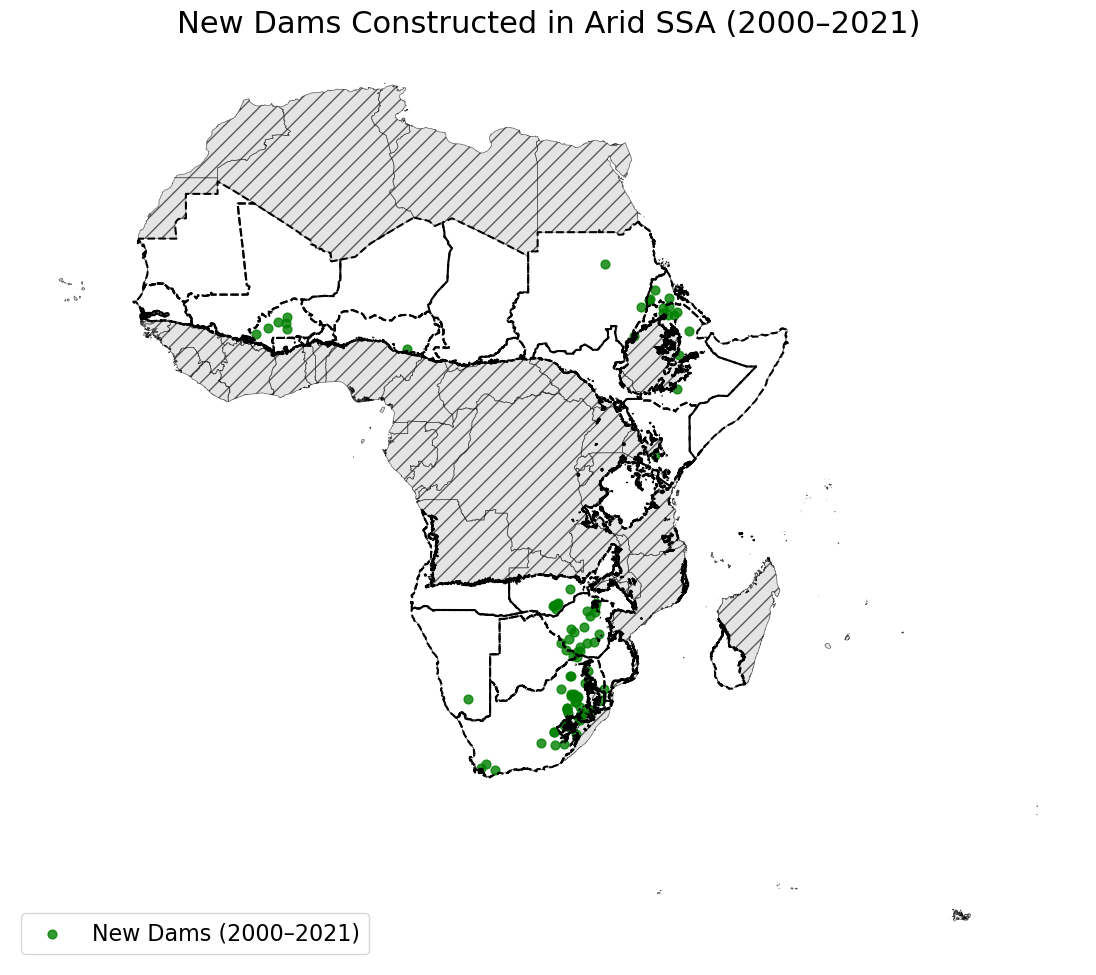

In [8]:
# --- Map of New Dams (2000–2021) ---
# Identify new dams: present in 2021 but not in 2000
ids_2000 = set(dams_2000_in_arid_ssa.index)
new_dams_2021 = dams_2021_in_arid_ssa[~dams_2021_in_arid_ssa.index.isin(ids_2000)]

fig, ax = plt.subplots(1, 1, figsize=(16, 12))
non_arid_ssa.plot(ax=ax, color='lightgray', edgecolor='black', hatch='//', linewidth=0.5, alpha=0.6)
arid_ssa_shapefile.boundary.plot(ax=ax, edgecolor='black', linewidth=1.5, linestyle='--')
new_dams_2021.plot(ax=ax, color='green', markersize=40, label='New Dams (2000–2021)', alpha=0.8)
ax.set_title('New Dams Constructed in Arid SSA (2000–2021)', fontsize=22)
ax.set_axis_off()
ax.legend(fontsize=16, loc='lower left')
plt.show()